# Importing libraries

In [ ]:
from google.colab import drive
import os
from time import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
# Nothing important, just to make colors white
# to see them better, since the background is gray
params = {"ytick.color" : "c",
          "xtick.color" : "c",
          "axes.labelcolor" : "c",
          "axes.edgecolor" : "c",
          "text.color" : "c"}
plt.rcParams.update(params)
%matplotlib inline

Using TensorFlow backend.


# Mounting the drive files

Since the images are on the google drive, I mounted the drive files into this colab's file system.

In [ ]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/data_')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Some parameters

In [ ]:
main_folder = 'train'
test_folder = 'test'
num_epochs = 200
batch_size = 32 # 64
image_size = 200 # 100
image_shape = (image_size, image_size, 3)

# Checking if all the folders inside of train folder has only images (files).

In [ ]:
def is_all_file(*p):
    path = '/'.join(map(str, p))
    return all([os.path.isfile(os.path.join(path, d)) for d in os.listdir(path)])

print(f'In {main_folder}:')
for i, room in enumerate(os.listdir(main_folder), 1):
    if is_all_file(main_folder, room):
        print(f'    {i}. {room} has all files')
    else:
        print(f'    {i}. {room} has some that are not files')

In train:
    1. Room has all files
    2. Out has all files
    3. Garden has all files
    4. Bathroom has all files
    5. Livingroom has all files
    6. Kitchen has all files
    7. Bedroom has all files
    8. Line has all files


# An example image before and after resizing

I resize the images since my model (will be defined later) will take an input as images with a fixed size and most of the images on the drive folder have different sizes.

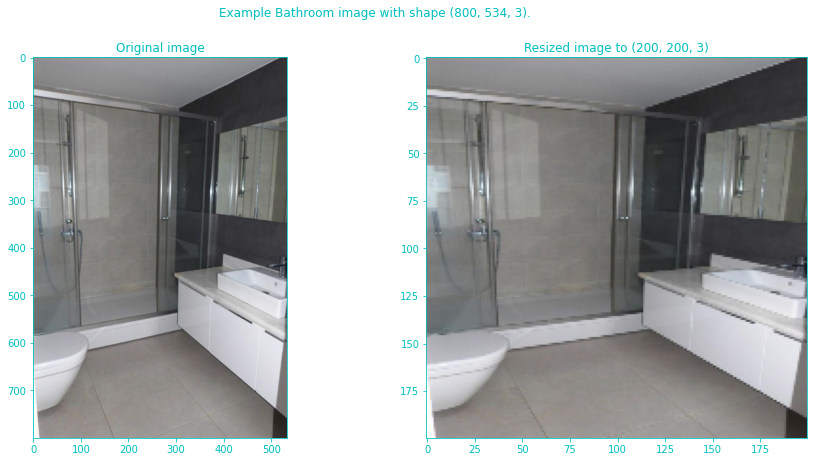

In [ ]:
image = cv2.imread('/content/drive/My Drive/data_/' + main_folder + '/Bathroom/bathroom  (324).jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
plt.suptitle(f'Example Bathroom image with shape {image.shape}.')
ax1.set_title('Original image')
ax1.imshow(image[:,:,::-1])
ax2.set_title(f'Resized image to {(image_size, image_size, 3)}')
ax2.imshow(cv2.resize(image, (image_size, image_size))[:,:,::-1])
plt.show()

# Reading all resized images

In [ ]:
allstart = time()

X, y = [], []
class_names = {}
num_rooms = len(os.listdir(main_folder))
for i, room in enumerate(os.listdir(main_folder)):
    print(f'Read {room}s', end=' ')
    start = time()
    room_path = os.path.join(main_folder, room)
    num_images = 0
    for filename in os.listdir(room_path):
        image = cv2.imread(os.path.join(room_path, filename))
        
        # I put this to see if none of the images gets longer or thicker
        # (I want all of them just to get shorter or thinner)
        # And this has never been printed, so I got what I want.
        h, w, c = image.shape
        if h < image_size:
            print(f'{filename} in {room} gets longer')
        if w < image_size:
            print(f'{filename} in {room} gets thicker')
        ####

        X.append(cv2.resize(image, (image_size, image_size)))
        y.append(np.eye(num_rooms)[i])
        class_names[i] = room

        num_images += 1

    print(f'in {time() - start:.2f} seconds. There are {num_images} images of {room}s.')

print()
print(f'### All read in {time() - allstart} seconds.')

Read Rooms in 4.10 seconds. There are 324 images of Rooms.
Read Outs in 4.39 seconds. There are 324 images of Outs.
Read Gardens in 1.75 seconds. There are 126 images of Gardens.
Read Bathrooms in 3.42 seconds. There are 324 images of Bathrooms.
Read Livingrooms in 4.32 seconds. There are 324 images of Livingrooms.
Read Kitchens in 7.37 seconds. There are 324 images of Kitchens.
Read Bedrooms in 2.00 seconds. There are 162 images of Bedrooms.
Read Lines in 0.74 seconds. There are 75 images of Lines.

### All read in 28.09508776664734 seconds.


# Getting the index of a room using its name

In [ ]:
def get_index_for(room:str):
    return [k for k, v in class_names.items() if v.lower().startswith(room.lower())][0]

def get_y_for(room:str):
    return np.eye(num_rooms)[get_index_for(room)]

def get_name_for(index):
    if np.isscalar(index):
        return class_names[int(index)]
    return get_name_for(np.argmax(index))

## Read test images

In [ ]:
allstart = time()

test_X, test_y = [], []
for i, room in enumerate(os.listdir(test_folder)):
    print(f'Read {room}s', end=' ')
    start = time()
    room_path = os.path.join(test_folder, room)
    num_images = 0
    for filename in os.listdir(room_path):
        image = cv2.imread(os.path.join(room_path, filename))
        
        # I put this to see if none of the images gets longer or thicker
        # (I want all of them just to get shorter or thinner)
        # And this has never been printed, so I got what I want.
        h, w, c = image.shape
        if h < image_size:
            print(f'{filename} in {room} gets longer')
        if w < image_size:
            print(f'{filename} in {room} gets thicker')
        ####

        test_X.append(cv2.resize(image, (image_size, image_size)))
        test_y.append(get_y_for(room))

        num_images += 1

    print(f'in {time() - start:.2f} seconds. There are {num_images} images of {room}s.')

print()
print(f'### All read in {time() - allstart} seconds.')

Read Lines in 0.23 seconds. There are 25 images of Lines.
Read Outs in 1.44 seconds. There are 108 images of Outs.
Read Livingrooms in 1.46 seconds. There are 108 images of Livingrooms.
Read Rooms in 1.18 seconds. There are 108 images of Rooms.
Read Bathrooms in 4.01 seconds. There are 108 images of Bathrooms.
Read Bedrooms in 0.82 seconds. There are 72 images of Bedrooms.
Read Gardens in 0.68 seconds. There are 47 images of Gardens.
Read Kitchens in 1.33 seconds. There are 108 images of Kitchens.

### All read in 11.163055658340454 seconds.


# Input images and their labels (which room are they)

In [ ]:
X = np.asarray(X)
y = np.asarray(y)
print('X.shape:', X.shape)
print('y.shape:', y.shape)

X.shape: (1983, 200, 200, 3)
y.shape: (1983, 8)


In [ ]:
test_X = np.asarray(test_X)
test_y = np.asarray(test_y)
print('test X.shape:', test_X.shape)
print('test y.shape:', test_y.shape)

test X.shape: (684, 200, 200, 3)
test y.shape: (684, 8)


# Image generator for randomization and data augmentation

In [ ]:
# image data generator keras
# https://keras.io/preprocessing/image/
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
datagen.fit(X)

In [ ]:
testgen = ImageDataGenerator()
datagen.fit(test_X)

validation_generator = testgen.flow(test_X, test_y,
        batch_size=batch_size)

# Creating the model

4 Convolutional layers (essential for image operations) and 2 Dense (Fully Connected) layers.

In [ ]:
model = Sequential()
model.add(Conv2D(512, kernel_size=5, activation='relu', input_shape=image_shape))
model.add(Conv2D(256, kernel_size=5, activation='relu'))
model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(num_rooms, activation='softmax'))

# Compiling model with adam optimizer (How to decrease the error) and categorical_crossentropy loss (How to measure the error)
model.compile(optimizer=Adam(0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Actual training

In [ ]:
history = model.fit_generator(datagen.flow(X, y, batch_size=batch_size), validation_data=validation_generator,
                              steps_per_epoch=len(X) / batch_size, epochs=num_epochs)

# for e in range(num_epochs):
#     print('Epoch', e)
#     for batches, (x_batch, y_batch) in enumerate(datagen.flow(X, y, batch_size=batch_size)):
#         model.fit(x_batch, y_batch)
#         if batches >= len(X) / batch_size:
#             # we need to break the loop by hand because
#             # the generator loops indefinitely
#             break

In [ ]:
# image = cv2.imread('/content/drive/My Drive/data_/' + main_folder + '/Bathroom/bathroom  (324).jpg')

index = 30
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
image = test_X[index]
ax.imshow(image[:,:,::-1])
ax.set_title(f'{get_name_for(test_y[index])}')
plt.show()

## Plotting the training performance

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(30, 7))
ax1.plot(history.history['acc'], label='Train')
ax1.plot(history.history['val_acc'], label='Validation')
l = ax1.legend()
plt.setp(l.get_texts(), color='k')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
l = ax2.legend()
plt.setp(l.get_texts(), color='k')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
plt.show()

# Tesing with unseen data (image) of `Out` class

In [ ]:
test_label = get_y_for('out')
test_images = []
for i, filename in enumerate(os.listdir('test/Out/')):
    image = cv2.imread(os.path.join('test/Out/', filename))
    image = cv2.resize(image, (image_size, image_size))
    test_images.append(image)

    print('i:', i)
    plt.imshow(image[:,:,::-1])
    plt.show()
    if i > 20:
        break

test_images = np.asarray(test_images)

# Predictions of the `Out` images

Most of them are `Out`s but the model and the data need improvement.

In [ ]:
pred = model.predict(test_images)
pred_index = pred.argmax(1)
# for i in pred_index:
#     print(class_names[i])
u, c = np.unique(pred_index, return_counts=True)
h = np.zeros(num_rooms)
h[u] = c
plt.bar(np.arange(num_rooms), h)
plt.show()
print(class_names)